# **DATA CLEANING NOTEBOOK**

## Objectives

* Clean data
* Split data into Train and Test sets

## Inputs

* outputs/datasets/collection/house_prices_records.csv

## Outputs

* Cleaned Test and Train data
* Generated data saved under outputs/datasets/cleaned




---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues'

# Load Data

In [4]:
! pip install pandas==1.4.2

In [5]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# Explore Missing Data

Let us see all columns with missing data

In [6]:
missing_data = df.columns[df.isna().sum() > 0].to_list()
missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

Install ydata-profiling and ipywidgets

In [7]:
! pip install ydata-profiling==4.4.0


In [8]:
! pip install ipywidgets==8.0.2

In [9]:
from ydata_profiling import ProfileReport
if missing_data:
    profile = ProfileReport(df=df[missing_data], minimal=True)
    profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the above report, it can be seen that
* 10 variables have missing data
* These 10 variables are: 
['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']
* 9 of the 10 variables have missing values
* 4 of the 10 variables have zeros
* '2ndFlrSF', 'EnclosedPorch' and 'WoodDeckSF' have both missing values and zeros

---

# Correlation and PPS

Install numpy, matplotlib, seaborn and ppscore

In [10]:
! pip install numpy==1.23.5 # to resolve compatibility errors with other packages
! pip install matplotlib==3.3.1
! pip install seaborn==0.11.0
! pip install ppscore==1.2.0

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

In [12]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculating Pearson, Spearman correlation and PPS

In [13]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%   75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.06  0.702


Preliminary finding: the PPScore mean of 0.055 indicates, on average, a low predictive power for the target variable. A 75% value of 0.06 means that 75% of the feature-target pairs have a PPS value of 0.06 or lower, indicating that only 25% of the pairs have slightly higher predictive power.

Next, we visualize the data:



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



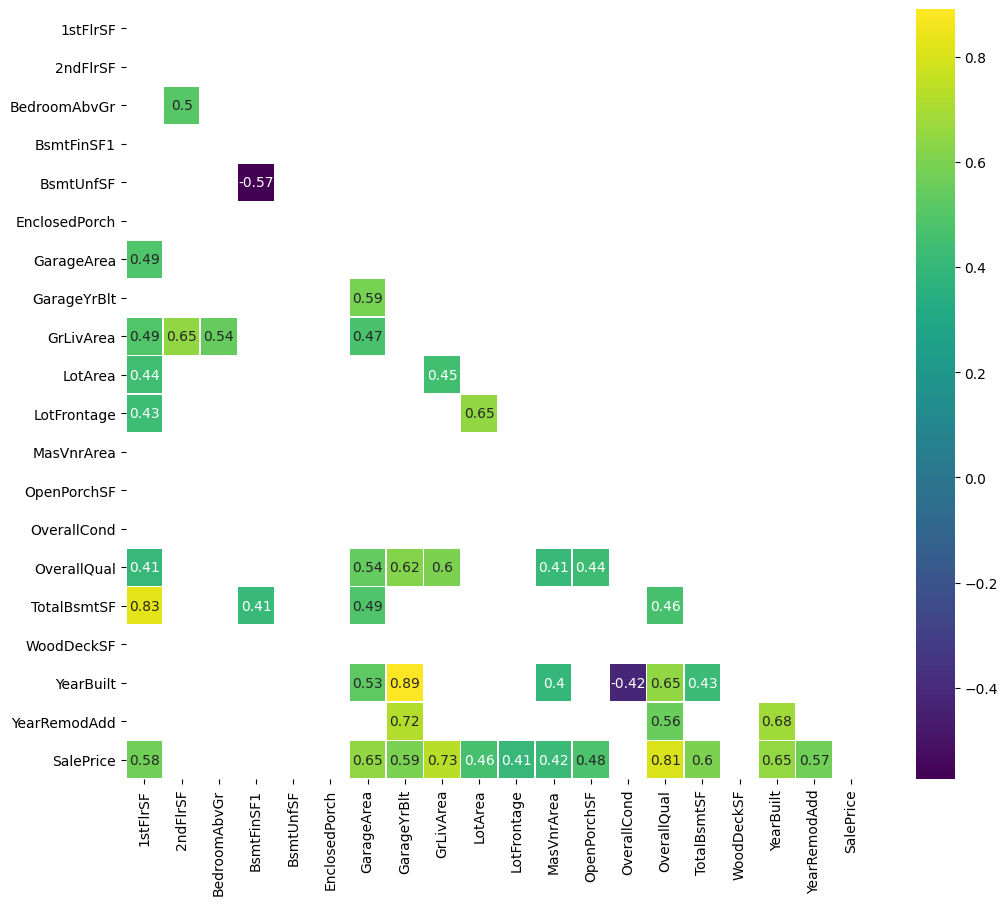



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



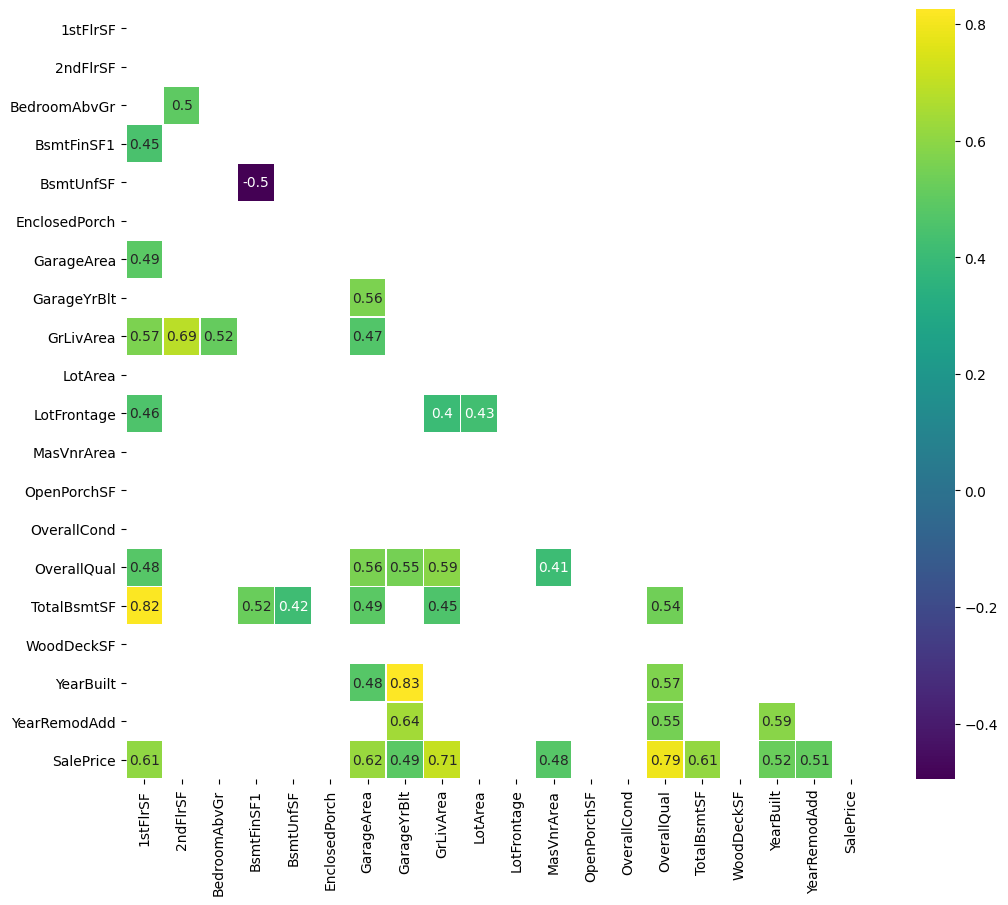



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



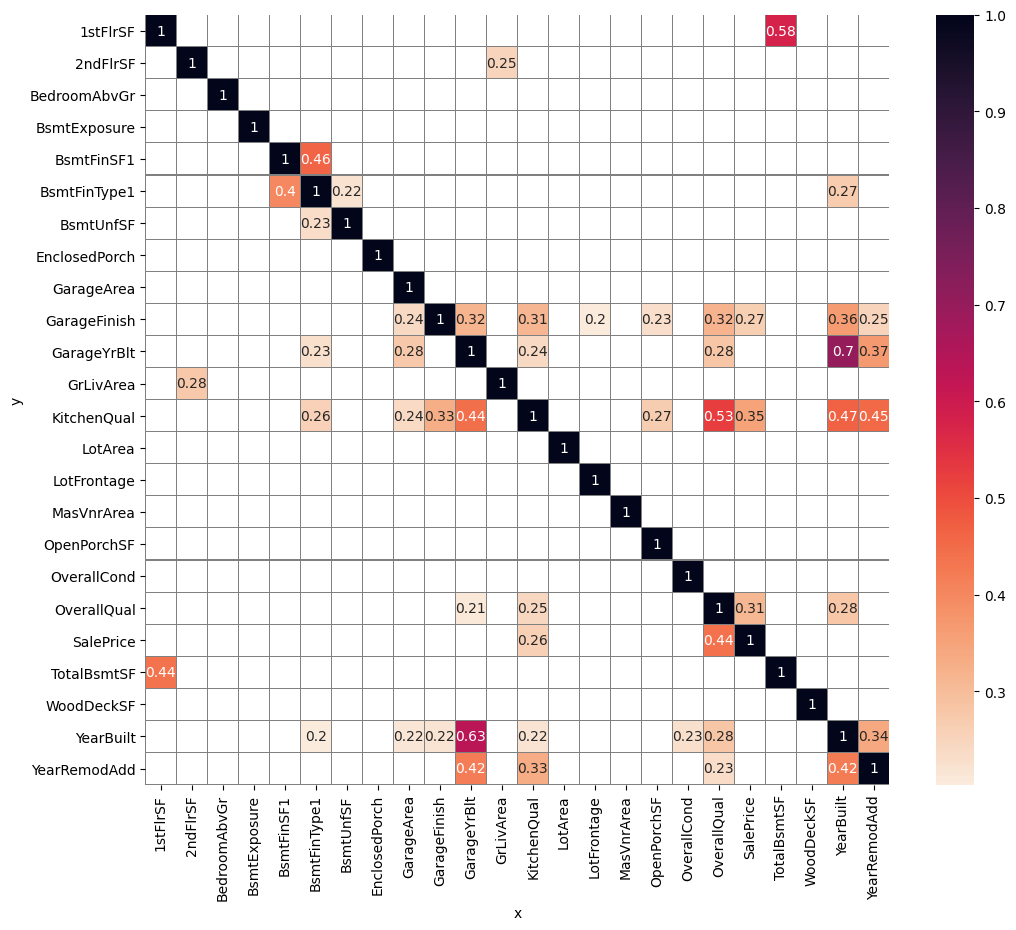

In [14]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

## Data Cleaning

We use CI's custom function to display missing data levels, looking at all rows which have missing data, how much data is missing per row in %, and the data type.

In [15]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

In [16]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,235,16.10,object
BsmtFinType1,145,9.93,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
BsmtExposure,38,2.60,object
MasVnrArea,8,0.55,float64


With the goal of preserving as much data as possible, let us review variables with missing data one by one.

Findings:

**Data to drop**
* `EnclosedPorch`: 90.68% of values are missing.
  * --> drop it due to large amount of missing data, and does not seem to have high predictive power for `SalePrice`.

* `WoodDeckSF`: 89.38% of values are missing.
  * --> drop it due to large amount of missing data, and does not seem to have high predictive power for `SalePrice`.

**Data to impute**
* `LotFrontage`: 17.74% of values are missing.
  * --> looking at the ProfileReport, the median should be imputed.

* `GarageFinish`: 16.10% of values are missing.
  * --> Data is presented as an object. Looking at the ProfileReport, 44.6% of the values are 'unf', meaning unfinished, which is the most common value. This is what shall be imputed.

* `BsmtFinType1`: 9.93% of values are missing.
  * --> Data is presented as an object. Looking at the ProfileReport, 30.1% of the values are 'unf', meaning unfinished, which is the most common value. This is what shall be imputed.

* `BedroomAbvGr`: 6.78% of values are missing.
  * --> Median imputation shall be used.

* `2ndFlrSF`: 5.89% of values are missing.
  * --> 53.5% of values are 0, indicating no second floor is present. We assume where a value is missing, 2nd floor is missing. Impute 0 for missing values.

* `GarageYrBlt`: 5.55% of values are missing.
  * --> Looking at Pearson, Spearman and the Heatmap, it is not surprising that the year built correlates strongly with the year in which the garage was built. For simplicity, the median shall be imputed.

* `BsmtExposure`: 2.60% of values are missing.
  * --> Data is presented as an object.  Looking at the ProfileReport, 67.0% of the values are 'no', which is the most common value. This is what shall be imputed.

* `MasVnrArea`: 0.55% of values are missing.
  * --> The most common value (59.0%) is 0. This is what shall be imputed.

## Drop Variables

In [17]:
! pip install feature-engine==1.0.2

In order to assess the effect of dropped data for each of the imputations we are about to make, we use CI's custom code:

In [18]:
def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

* Drop `EnclosedPorch` and `WoodDeckSF`

In [19]:
from feature_engine.selection import DropFeatures

variables_method = ['EnclosedPorch', 'WoodDeckSF']
variables_method

imputer = DropFeatures(features_to_drop=variables_method)
df_method = imputer.fit_transform(df)
df_method.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


Only 22 columns are left, previously it was 24 columns. This indicates the 2 columns were dropped.

## Impute Variables

### Arbitrary Number Imputation
* The number '0' shall be imputed for `2ndFlrSF` and `MasVnrArea`


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'MasVnrArea'] 




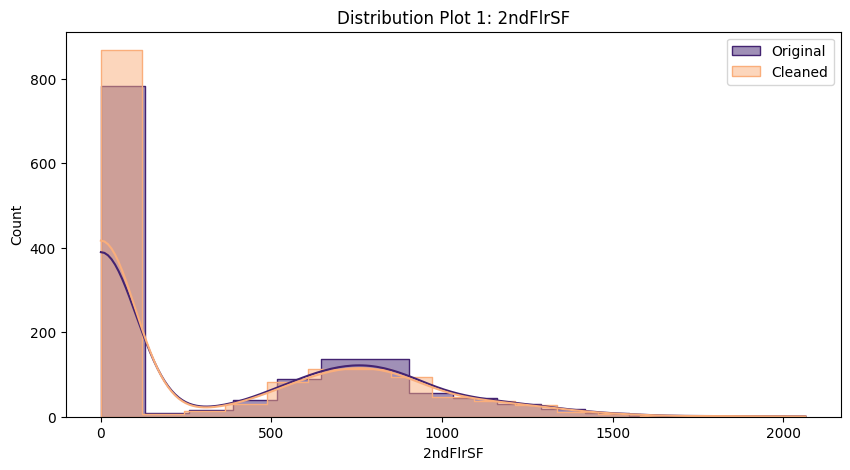

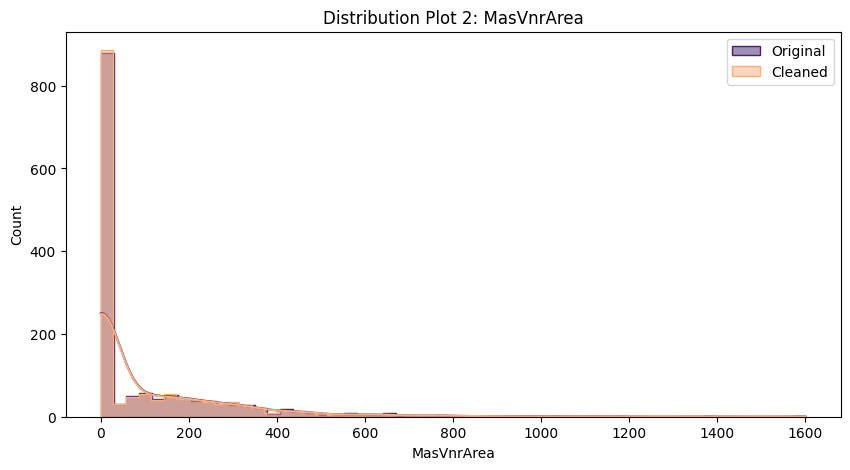

In [20]:
from feature_engine.imputation import ArbitraryNumberImputer

variables_method = ['2ndFlrSF', 'MasVnrArea']
variables_method

imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

We can see that the cleaned data has a similar distribution to the original data, indicating no major distortion by the cleaning.

### Median Imputation
* The median shall be imputed for `BedroomAbvGr`, `GarageYrBlt` and `LotFrontage`.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage'] 




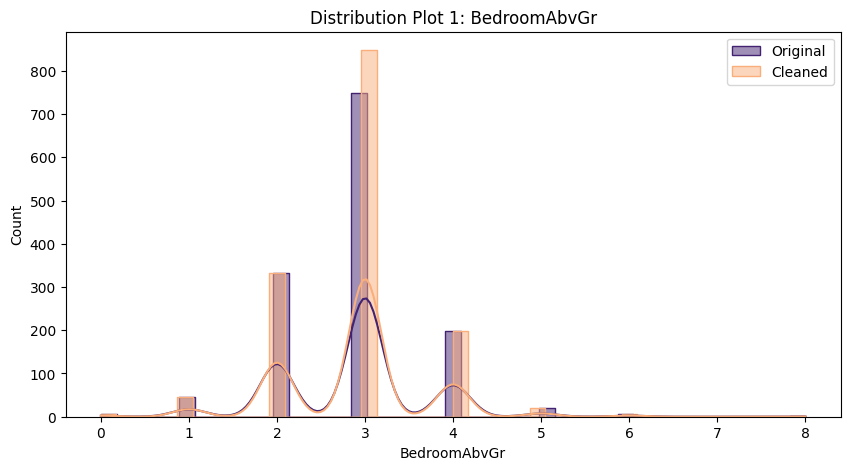

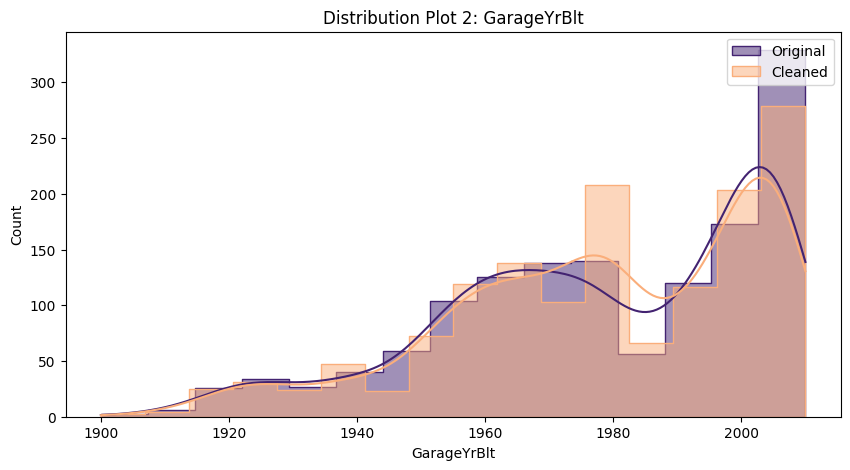

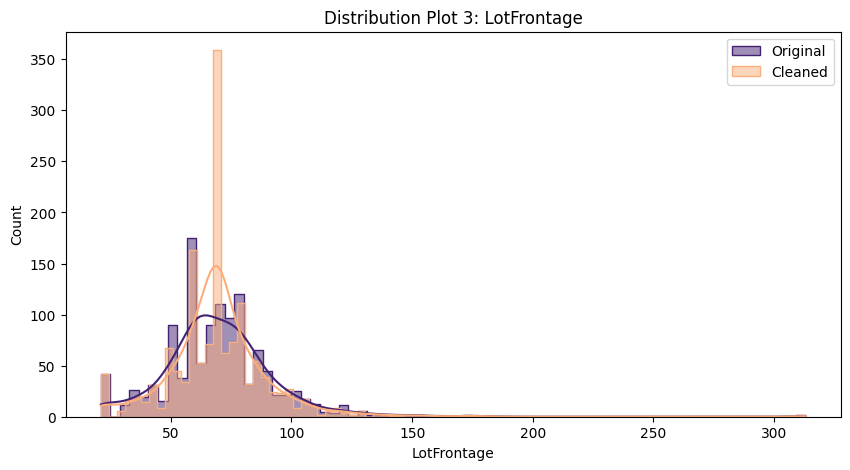

In [21]:
from feature_engine.imputation import MeanMedianImputer

variables_method = ['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']
variables_method

imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

We can see that the cleaned data has a similar distribution to the original data, albeit not completely the same. Still, this is considered acceptable as the graphs indicate no major distortion by the cleaning.

### Categorical Imputation
* The value 'Unf', due to being the most common one, shall be imputed for `BsmtFinType1` and `GarageFinish`.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['BsmtFinType1', 'GarageFinish'] 




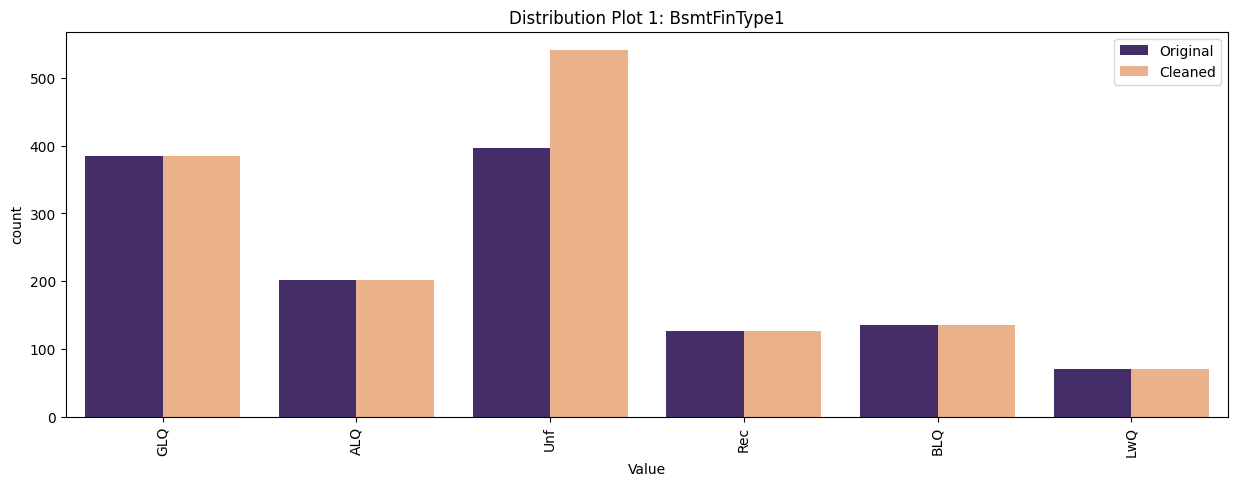

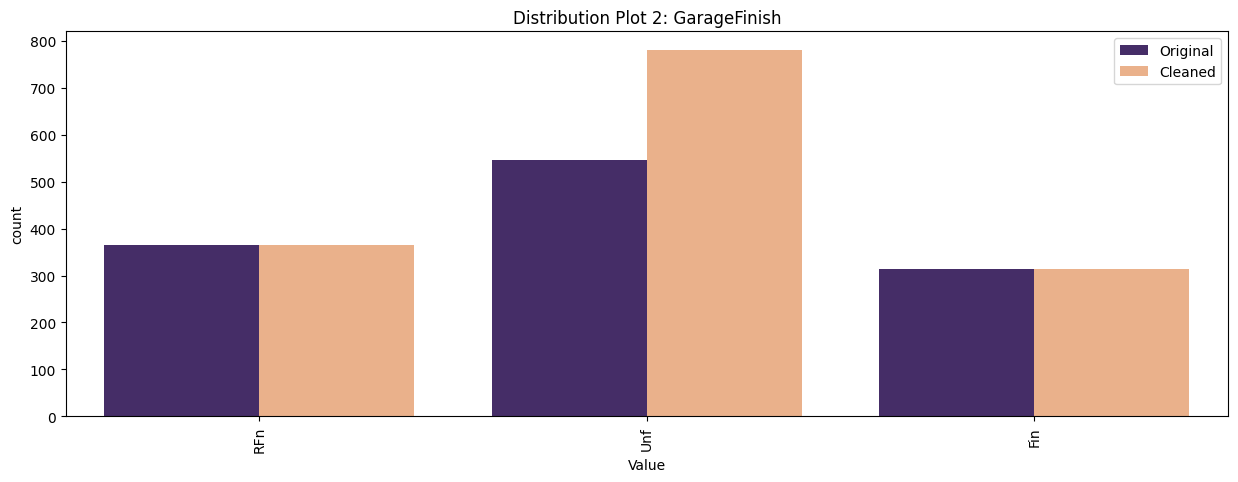

In [22]:
from feature_engine.imputation import CategoricalImputer

variables_method = ['BsmtFinType1', 'GarageFinish']
variables_method

imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

As expected, the cleaned data shows more values of 'Unf', which is what the imputation was supposed to achieve.

* The value 'No', due to being the most common one, shall be imputed for `BsmtExposure`.


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['BsmtExposure'] 




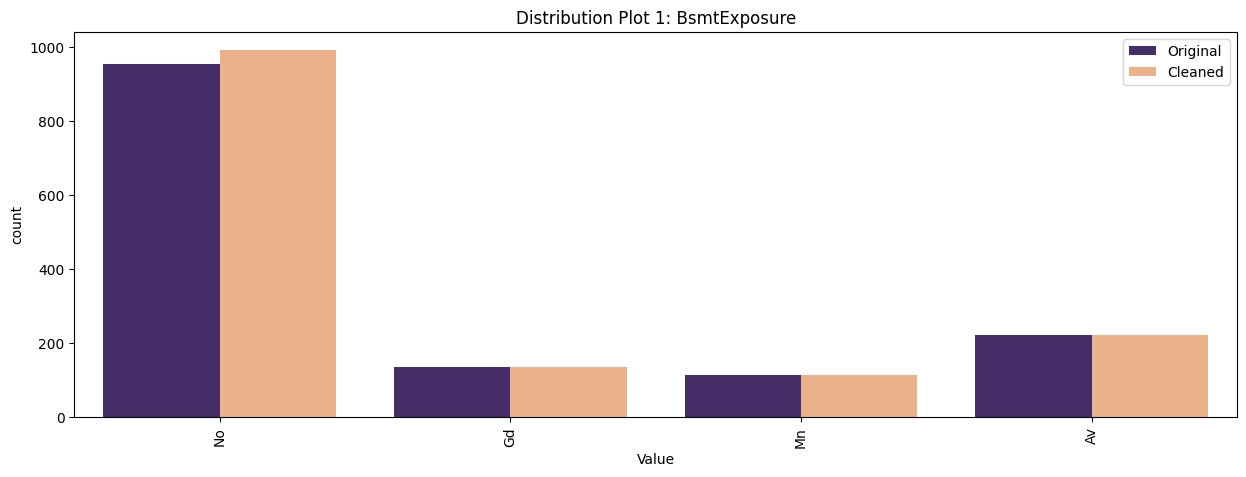

In [23]:
from feature_engine.imputation import CategoricalImputer

variables_method = ['BsmtExposure']
variables_method

imputer = CategoricalImputer(imputation_method='missing', fill_value='No', variables=variables_method)
df_method = imputer.fit_transform(df)

DataCleaningEffect(df_original=df,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_method)

As expected, the cleaned data shows more values of 'No', which is what the imputation was supposed to achieve.

# Split Train and Test Set

Now, the data shall be split into a train and a test set.

In [24]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


Next, the imputations are applied to both the Train and the Test Set.

In [25]:
# Drop Variables ['EnclosedPorch', 'WoodDeckSF']
variables_method = ['EnclosedPorch', 'WoodDeckSF']
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)

# ArbitraryNumberImputer 
variables_method = ['2ndFlrSF','MasVnrArea']
imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

# CategoricalImputer
variables_method = ['BsmtFinType1', 'GarageFinish']
imputer = CategoricalImputer(imputation_method='missing', fill_value='Unf', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

# CategoricalImputer
variables_method = ['BsmtExposure']
imputer = CategoricalImputer(imputation_method='missing', fill_value='No', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

# MeanMedianImputer
variables_method = ['BedroomAbvGr', 'GarageYrBlt', 'LotFrontage']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

Checking for missing data in the Train Set

In [26]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


Checking for missing data in the Test Set

In [27]:
df_missing_data = EvaluateMissingData(TestSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


---

# Push files to Repo

In [28]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


## Save Train Set

In [29]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Save Test Set

In [30]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)